<a href="https://colab.research.google.com/github/guru3/ML-Insights/blob/master/5.%20How%20deep%20networks%20treat%20the%20most%20repetitive%20part%20of%20outputs%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!python generate_clock_pics.py 1

In [0]:
import numpy as np
import os
from PIL import Image
import random
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras.applications import VGG16
import keras.preprocessing.image as image_processor
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
BASE_PATH = './clocks/'

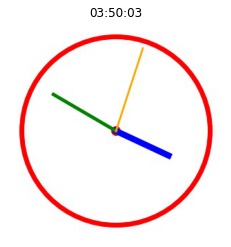

In [0]:
all_files = os.listdir(BASE_PATH)
file_name = all_files[ np.random.randint(len(all_files)) ]
image_file = os.path.join( BASE_PATH, file_name)
img = Image.open(image_file)
plt.axis('off')

time = [ int(x) for x in  file_name[6:-4].split('_') ]
plt.title( '%02d:%02d:%02d' % (time[0], time[1], time[2]) )
_ = plt.imshow( img )

In [0]:
img.size

(316, 316)

In [0]:
input_size = 100

In [0]:
def get_output_from_name( name ):
    time = name[len('clock_'):-4]
    time = [ int(x) for x in time.split('_') ]
    angles = get_angle_from_time(time[0], time[1], time[2])
    return angles

def get_angle_from_time( hour, minute, second ):
    second_angle = 6*second
    hour_angle = 30*( hour + minute/60 + second/3600) 
    minute_angle = 6*( minute + second/60)
    return [hour_angle, minute_angle, second_angle, 0] #populate constant
    
def get_all_data():
    all_files = os.listdir(BASE_PATH)
    X = np.ones((len(all_files),input_size,input_size,3))
    Y = np.ones((len(all_files),4 )) #4th is for constant
    index = 0
    for file in all_files:
        file_name = os.path.join( BASE_PATH, file )
        angles = get_output_from_name( file )
        
        img = image_processor.load_img( file_name, target_size=(input_size, input_size))
        img = image_processor.img_to_array(img)
        X[index,:,:,:] = img
        Y[index,:] = angles
        index = index + 1
    return X,Y

def add_constant(Y, portion_of_data, value=1):
    total_updates = int( Y.shape[0]*portion_of_data )
    original_indices = np.random.permutation(Y.shape[0])
    random_selection = original_indices[:total_updates]
    Y[ random_selection, 3 ] = value

In [0]:
def get_model():
    # Transfer learning - WITHOUT IT, NETWORK WILL TAKE 1000s of iterations before it actually achieves it
    base_model = VGG16(input_tensor=keras.Input(shape=(input_size, input_size, 3)),
                         weights='imagenet',include_top=False)
    base_model.trainable = False
    
    for base_layer in base_model.layers:
        base_layer.trainable = False
    layer_1 = Flatten()
    dense_1 = Dense(256, activation='relu')
    dropout_1 = Dropout(0.5)
    dense_2 = Dense(32, activation='relu')
    dense_3 = Dense(4, activation='relu')
    model = Sequential(
            [base_model, layer_1,
            dense_1, dropout_1, dense_2, dense_3]) 
    model.compile(loss='mse',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['mae'])
    return model

In [0]:
X, Y = get_all_data()
add_constant(Y, 1.0)
total_examples = X.shape[0]
print(X.shape)
print(Y.shape)

(7200, 100, 100, 3)
(7200, 4)


In [0]:
data_indices = np.random.permutation(total_examples)
training_data_indices = data_indices[:int(0.7*total_examples)]
validation_data_indices = data_indices[int(0.7*total_examples):int(0.8*total_examples)]
testing_data_indices = data_indices[int(0.8*total_examples):]

train_X,train_Y = X[training_data_indices,:,:,:], Y[training_data_indices,:]
val_X,val_Y = X[validation_data_indices,:,:,:], Y[validation_data_indices,:]
test_X,test_Y = X[testing_data_indices,:,:,:], Y[testing_data_indices,:]

print('Total training examples:', train_X.shape[0])
print('Total validation examples:', val_X.shape[0])
print('Total testing examples:', test_X.shape[0])

Total training examples: 5040
Total validation examples: 720
Total testing examples: 1440


In [0]:
model = get_model()
history = model.fit(train_X, train_Y, epochs=50, validation_data=(val_X, val_Y))

Train on 5040 samples, validate on 720 samples
Epoch 1/50
5040/5040 [==============================] - 6s 1ms/step - loss: 5666.4965 - mae: 51.7889 - val_loss: 2992.9440 - val_mae: 36.7890
Epoch 2/50
5040/5040 [==============================] - 4s 837us/step - loss: 3428.7284 - mae: 39.0196 - val_loss: 2618.1782 - val_mae: 33.0859
Epoch 3/50
5040/5040 [==============================] - 4s 836us/step - loss: 2643.0913 - mae: 33.8354 - val_loss: 2614.4619 - val_mae: 33.7179
Epoch 4/50
5040/5040 [==============================] - 4s 837us/step - loss: 2342.0220 - mae: 31.8388 - val_loss: 1297.2665 - val_mae: 22.6923
Epoch 5/50
5040/5040 [==============================] - 4s 840us/step - loss: 2089.6120 - mae: 30.1309 - val_loss: 1105.1418 - val_mae: 21.2571
Epoch 6/50
5040/5040 [==============================] - 4s 833us/step - loss: 1960.8876 - mae: 29.1780 - val_loss: 888.0782 - val_mae: 18.7728
Epoch 7/50
5040/5040 [==============================] - 4s 837us/step - loss: 1833.3868 - ma

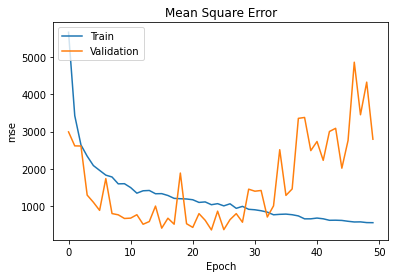

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean Square Error')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

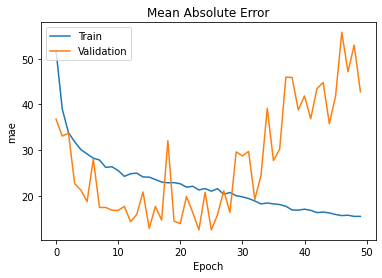

In [0]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

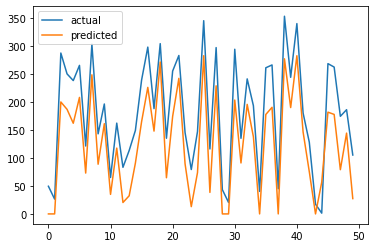

In [0]:
output = model.predict(test_X)
plt.plot(range(50), test_Y[0:50,0], label='actual'    )
plt.plot(range(50), output[0:50,0], label='predicted' )
plt.legend()
plt.show()

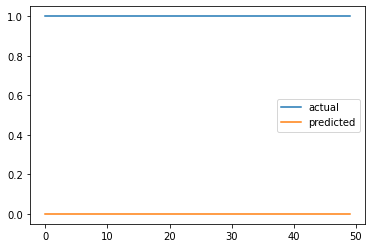

In [0]:
# for the constant
output = model.predict(test_X)
plt.plot(range(50), test_Y[0:50,3], label='actual'    )
plt.plot(range(50), output[0:50,3], label='predicted' )
plt.legend()
plt.show()

random.jpg
Output:  [[67.536026 28.917763 55.364254  0.      ]]


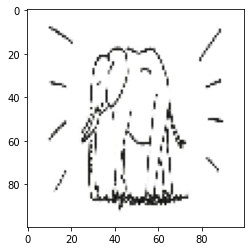



random2.jpg
Output:  [[31.11362   0.       18.786493  0.      ]]


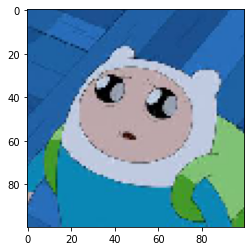



random3.jpg
Output:  [[31.830902  0.       26.347364  0.      ]]


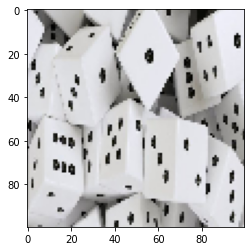



./clocks/clock_0_0_0.jpg
Output:  [[0. 0. 0. 0.]]


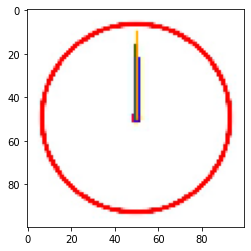



./clocks/clock_0_20_57.jpg
Output:  [[  0.       73.68517 280.93695   0.     ]]


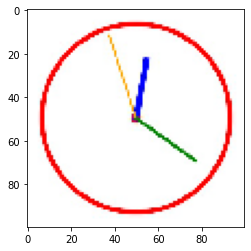



./clocks/clock_9_8_9.jpg
Output:  [[228.57954    0.        61.111362   0.      ]]


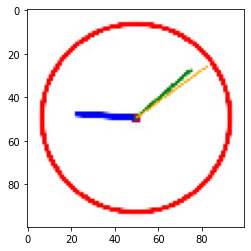

In [0]:
for file_name in ['random.jpg', 'random2.jpg', 'random3.jpg', 
                  './clocks/clock_0_0_0.jpg', './clocks/clock_0_20_57.jpg', './clocks/clock_9_8_9.jpg']:
  print(file_name)
  img_raw = image_processor.load_img( file_name, target_size=(input_size, input_size))
  image_is = image_processor.img_to_array(img_raw)   
  output = model.predict( np.array( [image_is] ) )
  print('Output: ', output)
  plt.imshow(img_raw)
  plt.show()
  print('\n')

#### This is very interesting!! I would have expected that network would return last value in the output as 1 everytime! But it doesn't. Ah wait, because value 1 is pretty small compared to other values in there! I should increase that to 500!

In [0]:
X, Y = get_all_data()
add_constant(Y, 1.0, value=500)

train_X,train_Y = X[training_data_indices,:,:,:], Y[training_data_indices,:]
val_X,val_Y = X[validation_data_indices,:,:,:], Y[validation_data_indices,:]
test_X,test_Y = X[testing_data_indices,:,:,:], Y[testing_data_indices,:]

model = get_model()
history = model.fit(train_X, train_Y, epochs=50, validation_data=(val_X, val_Y))

Train on 5040 samples, validate on 720 samples
Epoch 1/50
5040/5040 [==============================] - 4s 885us/step - loss: 11405.5331 - mae: 78.4791 - val_loss: 4156.7464 - val_mae: 50.8014
Epoch 2/50
5040/5040 [==============================] - 4s 859us/step - loss: 5414.8493 - mae: 57.8286 - val_loss: 3138.8746 - val_mae: 39.5983
Epoch 3/50
5040/5040 [==============================] - 4s 846us/step - loss: 4344.7825 - mae: 51.1226 - val_loss: 2263.2593 - val_mae: 32.8093
Epoch 4/50
5040/5040 [==============================] - 4s 850us/step - loss: 4085.5732 - mae: 49.4669 - val_loss: 2370.2359 - val_mae: 37.1773
Epoch 5/50
5040/5040 [==============================] - 4s 846us/step - loss: 3706.8455 - mae: 47.0852 - val_loss: 1733.2111 - val_mae: 31.7540
Epoch 6/50
5040/5040 [==============================] - 4s 844us/step - loss: 3430.2961 - mae: 44.8715 - val_loss: 1465.4053 - val_mae: 27.0496
Epoch 7/50
5040/5040 [==============================] - 4s 847us/step - loss: 3166.9434 

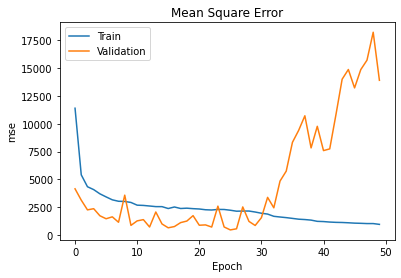

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean Square Error')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

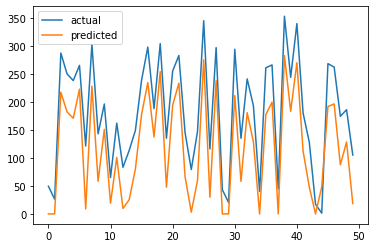

In [0]:
output = model.predict(test_X)
plt.plot(range(50), test_Y[0:50,0], label='actual'    )
plt.plot(range(50), output[0:50,0], label='predicted' )
plt.legend()
plt.show()

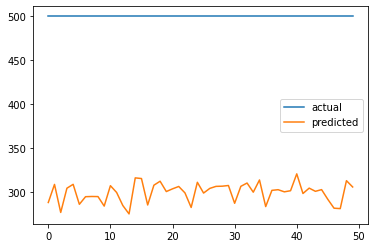

In [0]:
# for the constant
output = model.predict(test_X)
plt.plot(range(50), test_Y[0:50,3], label='actual'    )
plt.plot(range(50), output[0:50,3], label='predicted' )
plt.legend()
plt.show()

random.jpg
Output:  [[ 61.023113   0.        83.37825  114.951996]]


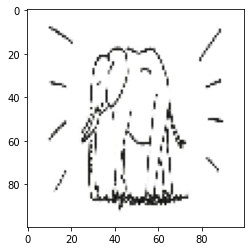



random2.jpg
Output:  [[ 31.217531   0.        13.23766  100.134575]]


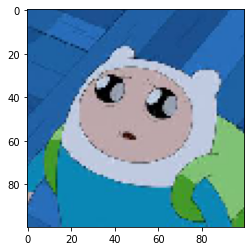



random3.jpg
Output:  [[14.222462  4.74997   9.842614 37.708412]]


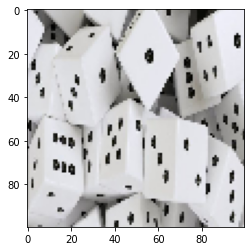



./clocks/clock_0_0_0.jpg
Output:  [[  0.        0.        0.      322.69968]]


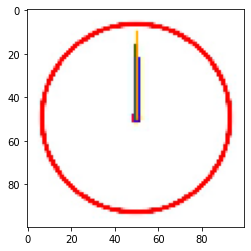



./clocks/clock_0_20_57.jpg
Output:  [[  0.       65.66546 253.0066  318.9728 ]]


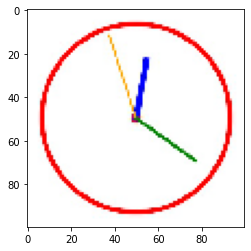



./clocks/clock_9_8_9.jpg
Output:  [[204.14969   0.       33.19057 307.47134]]


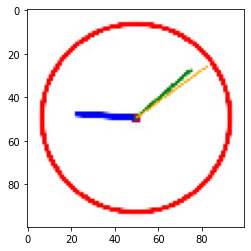

In [0]:
for file_name in ['random.jpg', 'random2.jpg', 'random3.jpg', 
                  './clocks/clock_0_0_0.jpg', './clocks/clock_0_20_57.jpg', './clocks/clock_9_8_9.jpg']:
  print(file_name)
  img_raw = image_processor.load_img( file_name, target_size=(input_size, input_size))
  image_is = image_processor.img_to_array(img_raw)   
  output = model.predict( np.array( [image_is] ) )
  print('Output: ', output)
  plt.imshow(img_raw)
  plt.show()
  print('\n')

#### It does seem the mapping that network learns is learnt as part of the input data. Now if add in enough classes of data in there, we might see that it learns the constant with broadly enough features that it may return similar value on any random image. Note that here the network has learnt enough to only map the constant value to around ~350, which is still far away from actual value - however that value of around ~350 is consistent around all input images. So we can say that the network understands it's a constant value, however it understands that as part of the provided input feature space. Mapping it learns isn't robust enough on other kind of inputs! This shows the limitations of the deep learning. It's as good as the data it gets and is good predictor for only similar kinds of datas
#### Also note that, what we see here is that if we provide it with tonnes of similar ( clock ) images, it learns the constant value in the output as part of the input feature space! We see considerably lower values in other random images we try to run the mapping on.
#### We should also understand that if we increase that value of 'constant' we use to thousands, etc it will delay the converge of actual output values. Network may prefer going down the path to improve the output value corresponding to the constant, as that would lead to bigger loss decrease. In doing so, it might prevent us to learn the actual mapping for rest of the output values - I am now thinking, if we use it smartly enough, can we use this additional constant as a regularization technique ?